# PIRIS + Bayesian Optimization
**Bayesian Optimization for hyperparameter tunning in PIRIS**


# Librerias

In [1]:
#Importamos ls librerias necesarias
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.io as pio
from sklearn.cluster import kmeans_plusplus
import pandas as pd
import tensorflow as tf
import optuna
from optuna.samplers import GPSampler
from optuna.visualization import (
    plot_param_importances,
    plot_contour
)

2025-08-08 12:04:51.512263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754654691.764375      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754654691.841690      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Parametros de creación de la muestra

a = 1.863  #Distancia de enlace Zn-O (A)
beta = 30*np.pi/180 #angulo de proyeccion de los lados del hexágono sobre el eje x en radianes
dist_x = 2*a*np.cos(beta) # distancia entre puntos en el eje x
dist_y = a*np.sin(beta) # distancia entre puntos en el eje y
offset_x = dist_x / 2 #offset de las filas impares a partir de la tercera fila
cols = 6# Número de columnas y filas
rows = 6

# Parametros del potencial L-J
kj_mol_to_ev = 0.01034 #Factor de conversion kj/mol a eV/atomo
SigmaO = 3.71 #Radio de vanderwalls del Oxigeno (A)
EpsilonO = 1.736 * kj_mol_to_ev #Fondo del pozo del Oxigeno (eV/atom)
SigmaNi = 2.834 #Radio de vanderwalls del Niquel (A)
EpsilonNi = 0.0628 *kj_mol_to_ev #Fondo del pozo Niquel (ev/atom)
SigmaZn = 4.045 #Radio de vanderwalls del Zinc (A)
EpsilonZn = 0.23 *kj_mol_to_ev #Fondo del pozo Zinc (ev/atom)
SigmaO_Ni = (SigmaO+SigmaNi)/2 #Constante sigma de interacción cruzada O-Ni 
EpsilonO_Ni = np.sqrt(EpsilonO*EpsilonNi) #Constante epsilon de interacción cruzada O-Ni 
SigmaZn_Ni = (SigmaZn+SigmaNi)/2 #Constante sigma de interacción cruzada Zn-Ni
EpsilonZn_Ni= np.sqrt(EpsilonZn*EpsilonNi) #Constante epsilon de interacción cruzada Zn-Ni 

# Parametros potencial coulomb
k_e = 14.3996 #Constante de coulomb en vacio en (eV A/e^2)
q_Ni = 2 #(carga del electron e)
q_O = -0.86 #(carga del electron e)
q_Zn = 0.86 #(carga del electron e)

# Radios de corte de intereacción basados en el potencial L-J
r_cutoffO_Ni = 2.5*SigmaO_Ni #Radio maximo de interacción Ni-O(A)
r_cutoffZn_Ni = 2.5*SigmaZn_Ni #Radio maximo de interacción Ni-Zn(A)
r_cutoffNi_Ni = 2.5*SigmaNi #Radio maximo de interacción Ni-Ni(A)

In [3]:
# Casteamos a tf los parametros
SigmaO_Ni = tf.cast(SigmaO_Ni, tf.float32)
EpsilonO_Ni = tf.cast(EpsilonO_Ni, tf.float32)
SigmaZn_Ni = tf.cast(SigmaZn_Ni, tf.float32)
EpsilonZn_Ni = tf.cast(EpsilonZn_Ni, tf.float32)
SigmaNi_Ni = tf.cast(SigmaNi, tf.float32)
EpsilonNi_Ni = tf.cast(EpsilonNi, tf.float32)
k_e = tf.cast(k_e,tf.float32)
q_Ni = tf.cast(q_Ni,tf.float32)
q_O = tf.cast(q_O,tf.float32)
q_Zn = tf.cast(q_Zn,tf.float32)
r_cutoffO_Ni = tf.cast(r_cutoffO_Ni, tf.float32)
r_cutoffZn_Ni = tf.cast(r_cutoffZn_Ni, tf.float32)
r_cutoffNi_Ni = tf.cast(r_cutoffNi_Ni, tf.float32)

I0000 00:00:1754654705.431149      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Creación de la muestra ZnO en forma Grafeno

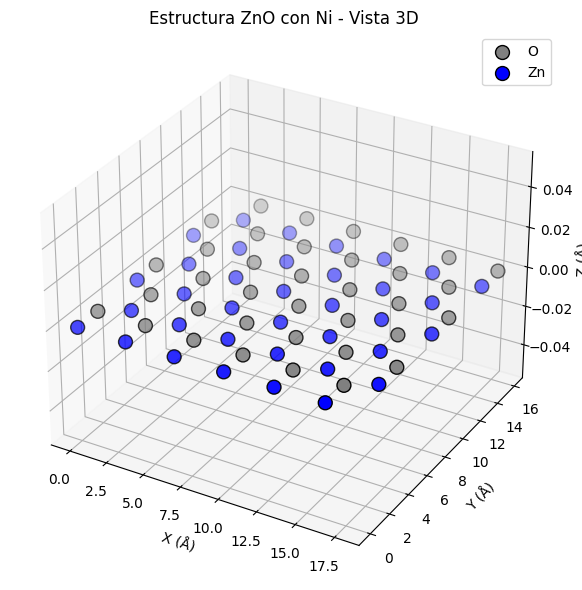

In [4]:
# Generar diccionario de coordenadas
coord_dict = {"Zn": [], "O": []}

for row in range(rows):
    y_zn = row * (a + dist_y)
    y_o = y_zn + a
    x_offset = offset_x if row % 2 == 1 else 0

    for col in range(cols):
        x = col * dist_x + x_offset
        coord_dict["Zn"].append((x, y_zn, 0))
        coord_dict["O"].append((x, y_o, 0))

positions = []
elements = []

for atom_type, coords in coord_dict.items():
    for pos in coords:
        positions.append(pos)
        elements.append(atom_type)



num_atoms = len(positions)
positions = np.array(positions)
elements = np.array(elements)
#tensorflow data
sample_atoms = tf.convert_to_tensor(positions,dtype=tf.float32)
sample_elements = tf.convert_to_tensor(elements, dtype=tf.string)

colors = {"Zn": "blue", "O": "grey"}

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

for atom_type in set(elements):
    idx = [i for i, e in enumerate(elements) if e == atom_type]
    pos = positions[idx]
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2],
               color=colors.get(atom_type, "black"),
               label=atom_type, s=100, edgecolors='k')

ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title("Estructura ZnO con Ni - Vista 3D")
ax.legend()
plt.tight_layout()
plt.show()

# kmeans++

**Para el k-means++, necesitamos unos limites alrededor de la superficie**

In [5]:
def calcular_limites_superficie(posiciones, padding=2.0):
    """
    Calcula los límites en (x,y) de una estructura atómica, añadiendo un margen.

    Args:
        posiciones (np.ndarray): Un array de forma (N, 3) con las coordenadas (x,y,z)
                                 de los átomos de la superficie.
        padding (float): Un margen en Angstroms que se añadirá en cada dirección
                         (min y max) a los límites de la estructura.

    Returns:
        tuple: Una tupla conteniendo los límites en X y Y. 
               Formato: ((x_min, x_max), (y_min, y_max))
    """
    if posiciones.ndim != 2 or posiciones.shape[1] < 2:
        raise ValueError("El array de posiciones debe tener forma (N, 2) o (N, 3).")
        
    # Extraer las coordenadas x e y
    x_coords = posiciones[:, 0]
    y_coords = posiciones[:, 1]
    
    # Encontrar los valores mínimos y máximos
    x_min, x_max = np.min(x_coords), np.max(x_coords)
    y_min, y_max = np.min(y_coords), np.max(y_coords)
    
    # Aplicar el padding
    limites_x = (x_min - padding, x_max + padding)
    limites_y = (y_min - padding, y_max + padding)
    
    print(f"Límites de la estructura calculados:")
    print(f"  - Rango X (con padding): ({limites_x[0]:.2f}, {limites_x[1]:.2f})")
    print(f"  - Rango Y (con padding): ({limites_y[0]:.2f}, {limites_y[1]:.2f})")
    
    return limites_x, limites_y

# Creación de los iones que se van a adsorber

**Vamos a tratar la altura Z como un hiperparametro a optmizar**

**Definimos la creacion de los iones como una función, para llamarla dentro del loop de BO** 

In [6]:
def generate_xy(malla, k_simulaciones, num_ni_por_simulacion, random_seed=42):
    """
    Selecciona 'k_simulaciones' conjuntos de 'num_ni_por_simulacion' posiciones (x,y)
    cada uno.

    Args:
        malla (np.ndarray): Array de posiciones candidatas (N, 2).
        k_simulaciones (int): Número de simulaciones/configuraciones a generar.
        num_ni_por_simulacion (int): Número de iones en cada simulación.
        random_seed (int): Semilla para reproducibilidad.

    Returns:
        list: Una lista de 'k_simulaciones' arrays. Cada array tiene forma 
              (num_ni_por_simulacion, 2) y representa una configuración inicial.
    """
    total_puntos_a_seleccionar = k_simulaciones * num_ni_por_simulacion
    
    if total_puntos_a_seleccionar > malla.shape[0]:
        raise ValueError("El número total de puntos a seleccionar (k * num_ni) excede el tamaño de la malla.")

    # 1. Usar k-means++ para seleccionar un gran conjunto de puntos bien espaciados
    puntos_seleccionados, _ = kmeans_plusplus(
        malla, 
        n_clusters=total_puntos_a_seleccionar, 
        random_state=random_seed
    )
    
    print(f"Se han seleccionado {total_puntos_a_seleccionar} puntos en total con k-means++.")
    
    # 2. Agrupar estos puntos en 'k_simulaciones' configuraciones
    configuraciones = np.array_split(puntos_seleccionados, k_simulaciones)
    
    print(f"Se han agrupado en {len(configuraciones)} configuraciones de {num_ni_por_simulacion} iones cada una.")
    
    return configuraciones
        
def build_ions(xy_positions,z):
    """Recibe posiciones xy pre definidas y la altura z para combinarlas y generar los iones
    a adsorber
    args: 
        xy_positions:array con un conjunto de posiciones xy preseleccionadas.
        z: float de altura optimizable por optuna
    returns:
        np.ndarray: Array de forma (num_ni, 3) con las posiciones completas (x,y,z)"""
    #Tomamos la cantidad de iones del array de coordenaads xy
    num_ni = xy_positions.shape[0]
    # Crea una columna de 'z' con el mismo valor para todos los iones
    z_column = np.full((num_ni, 1), z)
    
    # Concatena las posiciones (x,y) con la columna z
    ion_positions = np.hstack([xy_positions, z_column])
    
    return ion_positions


**Tambien definimos una funcion para el muestreo de posibles coordenadas xy usando k-means++**

In [7]:
def xy_candidate_selection(limites_x, limites_y, puntos_por_eje):
    """
    Construye una malla 2D de posibles posiciones iniciales dados unos límites.

    Args:
        limites_x (tuple): Una tupla (x_min, x_max).
        limites_y (tuple): Una tupla (y_min, y_max).
        puntos_por_eje (int): Número de puntos a generar por cada eje.

    Returns:
        np.ndarray: Un array de forma (N, 2) con las coordenadas (x, y) de la malla.
    """
    # Generar los puntos en cada eje usando los límites calculados
    x_coords = np.linspace(limites_x[0], limites_x[1], puntos_por_eje)
    y_coords = np.linspace(limites_y[0], limites_y[1], puntos_por_eje)
    
    # Crear la malla usando meshgrid
    xx, yy = np.meshgrid(x_coords, y_coords)
    
    # Aplanar y combinar en un array de coordenadas (N, 2)
    malla = np.vstack([xx.ravel(), yy.ravel()]).T
    
    print(f"Malla de {malla.shape[0]} posiciones candidatas creada sobre los límites definidos.")
    return malla

# Definición del costo para entrenamiento y evaluación.

**Costo de entrenamiento**

In [8]:
# Lennard-Jones potential function
@tf.function
def physical_potential(r, epsilon, sigma, q_j):
    sr6 = tf.math.pow(sigma / r, 6)
    sr12 = tf.math.pow(sr6, 2)
    lj = 4.0 * epsilon * (sr12 - sr6) + epsilon # Sumamos epsilon para dejar el fondo del pozo en 0
    coulomb = k_e * q_Ni * q_j / tf.maximum(r, 1e-10)
    return lj + coulomb

# Funcion para calcular el potencial de informacion, individual y cruzado
@tf.function
def calculate_cross_information_potential(points1, points2, sigma):
    """
    Calcula el Potencial de Información Cruzado (V) entre dos conjuntos de puntos.
    Si points1 y points2 son el mismo, calcula el Potencial de Información (IP).
    """
    diff = tf.expand_dims(points1, 1) - tf.expand_dims(points2, 0)
    sq_dists = tf.reduce_sum(tf.square(diff), axis=-1)
    kernel_matrix = tf.exp(-sq_dists / (2.0 * sigma**2))
    return tf.reduce_mean(kernel_matrix)
    
# Función de costo para el entrenamiento del modelo
@tf.function
def get_training_loss(positions, elements, ni_positions, pri_weight, lambda_pri, sigma_pri):
     """
    Calcula la energía total de las interacciones entre los iones (ni_positions) y la superficie (positions),
    utilizando un potencial fisico y una regularizacion por PRI.
    Parameters:
        Ni_positions: tensor con posiciones de los iones (num_iones, 3)
        Positions: tensor con posiciones de los átomos de la superficie (num_atoms, 3)
        Elements: tensor con etiquetas de tipo de atomo (num_superficie,)
        pri_weight,lambda_pri,sgma_pri: hiperparametros escalares que modelan el peso de la regulaización
    Returns:
        Energía total del sistema (escalar)
        Energía total de cada ion (num_iones,)
    """
    
    #----------------------INTERACCIONES ION-NANOESTRUCTURA-------
    # Expandir dimensiones para obtener todas las combinaciones de distancias ion-atomo
     pos_exp = tf.expand_dims(positions, axis=1)  # (num_atoms, 1, 3)
     ni_exp = tf.expand_dims(ni_positions, axis=0)  # (1, num_iones, 3)
   
     r = tf.norm(pos_exp - ni_exp, axis=2)  # Uso la norma para calcular la magnitud de la distancia 
                                # entre cada ion y cada átomo de la superficie (num_iones, num_atoms)
     
    # Casteamos las etiquetas para que tengan la forma de r
     elements_exp = tf.reshape(elements, (-1, 1))  # (num_atoms, 1)

    # Creamos una mascara para etiquetar las interacciones
     is_O = tf.equal(elements_exp, "O")
     is_Zn = tf.equal(elements_exp, "Zn")


    # Calculamos la energía aplicando cortes de distancia de interacción
     energy_O = tf.where(r < r_cutoffO_Ni,
                        physical_potential(r, EpsilonO_Ni, SigmaO_Ni,q_O),
                        tf.zeros_like(r))
     energy_Zn = tf.where(r < r_cutoffZn_Ni,
                         physical_potential(r, EpsilonZn_Ni, SigmaZn_Ni, q_Zn),
                         tf.zeros_like(r))
    # Filtramos el valor de la energía dependiendo de la etiqueta
     atoms_energy_matrix = tf.where(is_O, energy_O,
                            tf.where(is_Zn, energy_Zn, tf.zeros_like(r)))
    # Energía total por ion (sumando sobre átomos)
     energy_per_ion = tf.reduce_sum(atoms_energy_matrix, axis=0)  # shape: (num_ions,)

    # --------
    # Esta sección maneja la energía promedio por ion, por ahora no se esta usando
    # Calculamos la energia promedio por ion considerando que no todos interactuan con la misma
    # cantidad de atomos.
    # Definimos mascaras para contar las interacciones validas
     mask_O = tf.cast(tf.less(r, r_cutoffO_Ni), tf.float32) * tf.cast(is_O, tf.float32)
     mask_Zn = tf.cast(tf.less(r, r_cutoffZn_Ni), tf.float32) * tf.cast(is_Zn, tf.float32)
     interaction_mask_atoms = tf.maximum(mask_O, mask_Zn)  # shape: (num_atoms, num_ions)
    # Número de interacciones válidas por ion
     count_per_ion = tf.reduce_sum(interaction_mask_atoms, axis=0)  # shape: (num_ions,)
     count_per_ion_safe = tf.where(count_per_ion == 0, 1.0, count_per_ion)  # evitar división por cero
    # Energia promedio de cada ion
     mean_energy_per_ion = energy_per_ion / count_per_ion_safe  # shape: (num_ions,)
    #---------


    #----------------------INTERACCIONES ION-ION-------
    # Calcula matriz de vectores diferencia entre iones
     diff_ion = tf.expand_dims(ni_positions, 0) - tf.expand_dims(ni_positions, 1)  # (num_ions, num_ions, 3)
    # Calcula matriz de distancias usando norma
     r_ion = tf.norm(diff_ion, axis=-1)  # (num_ions, num_ions)

    # Construye máscaras para excluir la diagonal y aplicar cutoff
     eye = tf.eye(tf.shape(ni_positions)[0], dtype=tf.bool)  # diagonal True
     mask_offdiag = tf.logical_not(eye)  # off-diagonal True
     mask_cutoff = tf.less(r_ion, r_cutoffNi_Ni)  # True si r < cutoff
     interaction_mask_ions = tf.logical_and(mask_offdiag, mask_cutoff)  # pares válidos distintos
    # Prepara distancias válidas evitando divisiones por cero
     valid_r = tf.where(interaction_mask_ions, tf.maximum(r_ion, 1e-10), tf.ones_like(r_ion))

    # Calcula energía Lennard-Jones solo en pares válidos
     ion_energy_matrix = tf.where(interaction_mask_ions,
                             physical_potential(valid_r, EpsilonNi_Ni, SigmaNi_Ni, q_Ni),
                             tf.zeros_like(r_ion))
    # Energías totales ion_ion
     ion_ion_energy_per_ion = tf.reduce_sum(ion_energy_matrix, axis=0)  # (num_ions,)
    
    # --------
    # Esta sección maneja la energía promedio por ion, por ahora no se esta usando
    # Número de interacciones válidas por ion
     count_per_ion_ion = tf.reduce_sum(tf.cast(interaction_mask_ions, tf.float32), axis=0)  # (num_ions,)
     count_per_ion_ion_safe = tf.where(count_per_ion_ion == 0, 1.0, count_per_ion_ion)
    # Energias promedio ion_ion
     mean_ion_ion_energy_per_ion = ion_ion_energy_per_ion / count_per_ion_ion_safe  # (num_ions,)
    #---------------
    
    # calcular la energía total del sistema y la energía por ion
     ion_ion_total_energy = tf.reduce_sum(ion_ion_energy_per_ion) * 0.5 #Multiplico por 0.5 porque la energia aparece una vez para cada ion
     energy_total_per_ion = energy_per_ion + ion_ion_energy_per_ion
     energy_total = tf.reduce_sum(energy_per_ion)+ion_ion_total_energy

    #--------------------REGULARIZACIÓN CON PRI----------------------
    # Analogía: positions -> majority class | ion_positions -> undersampled majority class 

     epsilon_log = 1e-10  # Para estabilidad numérica en el logaritmo

    # Calcular potenciales de información
     ip_ions = calculate_cross_information_potential(ni_positions, ni_positions, sigma_pri)
     ip_surface = calculate_cross_information_potential(positions, positions, sigma_pri) # Es constante, pero se calcula aquí por simplicidad
     cip_ions_surface = calculate_cross_information_potential(ni_positions, positions, sigma_pri)
    # Calcular entropías cuadráticas (H2 = -log(V))
     H2_ions = -tf.math.log(ip_ions + epsilon_log)
     H2_surface = -tf.math.log(ip_surface + epsilon_log)
     H2_cross = -tf.math.log(cip_ions_surface + epsilon_log)

    # Calcular Divergencia de Cauchy-Schwarz (D_cs= 2H2(ion,surface)- H2(ion)- H2(surface)) - Eq. 4 del paper
     D_cs = 2 * H2_cross - H2_ions - H2_surface
    # Calcular costo PRI - Eq. 7 del paper
    # J(X_hat) = H2(X_hat) + lambda * D_cs(X_hat, X)
     pri_cost = (1- lambda_pri)*H2_ions + 2*lambda_pri * D_cs

    #------------COMBINAR Y RETORNAR----------------

     total_loss = energy_total + pri_weight * pri_cost
    
     return  total_loss, energy_total_per_ion

**Costo de evaluación**

In [9]:
@tf.function
def calculate_final_system_energy(positions, elements, ni_positions):
    """
    Calcula la energía del sistema sin PRI y corrige el shift potencial de la energía
    """
    pos_exp = tf.expand_dims(positions, axis=1)
    ni_exp = tf.expand_dims(ni_positions, axis=0)
    r = tf.norm(pos_exp - ni_exp, axis=2)
    elements_exp = tf.reshape(elements, (-1, 1))
    is_O = tf.equal(elements_exp, "O")
    is_Zn = tf.equal(elements_exp, "Zn")
    
    energy_O = tf.where(r < r_cutoffO_Ni, physical_potential(r, EpsilonO_Ni, SigmaO_Ni, q_O), tf.zeros_like(r))
    energy_Zn = tf.where(r < r_cutoffZn_Ni, physical_potential(r, EpsilonZn_Ni, SigmaZn_Ni, q_Zn), tf.zeros_like(r))
    atoms_energy_matrix = tf.where(is_O, energy_O, tf.where(is_Zn, energy_Zn, tf.zeros_like(r)))
    energy_per_ion = tf.reduce_sum(atoms_energy_matrix, axis=0)

    diff_ion = tf.expand_dims(ni_positions, 0) - tf.expand_dims(ni_positions, 1)
    r_ion = tf.norm(diff_ion, axis=-1)
    eye = tf.eye(tf.shape(ni_positions)[0], dtype=tf.bool)
    mask_offdiag = tf.logical_not(eye)
    mask_cutoff = tf.less(r_ion, r_cutoffNi_Ni)
    interaction_mask_ions = tf.logical_and(mask_offdiag, mask_cutoff)
    valid_r = tf.where(interaction_mask_ions, tf.maximum(r_ion, 1e-10), tf.ones_like(r_ion))
    ion_energy_matrix = tf.where(interaction_mask_ions, physical_potential(valid_r, EpsilonNi_Ni, SigmaNi_Ni, q_Ni), tf.zeros_like(r_ion))
    ion_ion_energy_per_ion = tf.reduce_sum(ion_energy_matrix, axis=0)
    
    ion_ion_total_energy = tf.reduce_sum(ion_ion_energy_per_ion) * 0.5
    physical_energy_total = tf.reduce_sum(energy_per_ion) + ion_ion_total_energy
    
    # --- Apply the final epsilon correction ---
    mask_O = tf.cast(tf.less(r, r_cutoffO_Ni), tf.float32) * tf.cast(is_O, tf.float32)
    mask_Zn = tf.cast(tf.less(r, r_cutoffZn_Ni), tf.float32) * tf.cast(is_Zn, tf.float32)
    num_interactions_O = tf.reduce_sum(tf.cast(mask_O, tf.float32))
    num_interactions_Zn = tf.reduce_sum(tf.cast(mask_Zn, tf.float32))
    num_interactions_ionion = tf.reduce_sum(tf.cast(interaction_mask_ions, tf.float32))*0.5 #igual que en la energía, las interacciones se cuentan doble
    total_epsilon_shift = (
        num_interactions_O * EpsilonO_Ni +
        num_interactions_Zn * EpsilonZn_Ni +
        num_interactions_ionion * EpsilonNi_Ni
    )
    corrected_energy_total = physical_energy_total - total_epsilon_shift
    
    return corrected_energy_total, energy_per_ion + ion_ion_energy_per_ion

**Definmos un exponential decay learning rate**

In [10]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** (epoch/5)

**Definimos clase para early stop**

In [11]:
# Early_stop Callback class
class EarlyStoppingCallback:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = float('inf')
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                return True  # Signal to stop training
        return False  # Continue training

# Bayesian Optimization

**Definimos la funcion objetivo de la optimización bayesiana**

In [12]:
def objective(trial):
    """
    Objective function for Optuna to minimize.
    It runs the PIRIS simulation for a given set of hyperparameters.
    """
    # --- 1. Suggest hyperparameters from the trial object ---
    # Z-height: range is based on physical constants
    z_min_bound = float(SigmaO_Ni.numpy())
    z_max_bound = float(8 * SigmaZn_Ni.numpy()) # A reasonable upper bound based on cutoff radius and PRI reach
    z_initial = trial.suggest_float("z", z_min_bound, z_max_bound)

    # PRI hyperparameters
    pri_weight_val = trial.suggest_float("pri_weight", 1.0, 10.0) #Up to 10 given the magnitude of H vs PRI loss
    lambda_pri_val = trial.suggest_float("lambda_pri", 0.0, 1.0)
    
    # Sigma_pri: search space follows the magnitude of z
    sigma_pri_val = trial.suggest_float("sigma_pri", 1.0, 8*SigmaZn_Ni.numpy(), log=True)# A reasonable range follows z distribution

    # Use the learning rate and decay rate suggested by the trial
    eta0 = trial.suggest_float("learning_rate", 1e-3, 5e-1, log=True)
    decay_rate = trial.suggest_float("decay_rate", 0.90, 0.99)

    # --- 2. Setup the simulation for this trial ---
    # Traemos de los atributos del trial la posicion inicial
    position_str = trial.study.user_attrs["starting_position"]
    # Convert the JSON string back into a Python list/array
    xy_positions = np.array(json.loads(position_str))
    # Create the initial ion positions with the suggested z
    initial_ni_positions = build_ions(xy_positions, z=z_initial)
    ion = tf.Variable(initial_ni_positions, dtype=tf.float32)

    # Cast hyperparameters to TensorFlow constants for this trial
    pri_weight = tf.constant(pri_weight_val, dtype=tf.float32)
    lambda_pri = tf.constant(lambda_pri_val, dtype=tf.float32)
    sigma_pri = tf.constant(sigma_pri_val, dtype=tf.float32)

    # --- 3. Run the training loop ---
    epochs = 200  # Reduced for faster optimization trials
    optimizer = tf.keras.optimizers.Adam(learning_rate=eta0)

    for epoch in range(epochs):
        eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
        optimizer.learning_rate.assign(eta)
        
        with tf.GradientTape() as g:
            g.watch(ion)
            H_loss, _ = get_training_loss(sample_atoms, sample_elements, ion.value(), pri_weight, lambda_pri, sigma_pri)
        
        grad_ = g.gradient(H_loss, ion)
        
        # Check for NaN gradients which can happen with extreme hyperparameters
        if tf.reduce_any(tf.math.is_nan(grad_)):
            # If gradients are NaN, the trial is bad. Return a large value.
            return 1e6

        optimizer.apply_gradients(zip([grad_], [ion]))

    # --- 4. Calculate final energy and return it ---
    final_energy, _ = calculate_final_system_energy(sample_atoms, sample_elements, ion.value())
    
    return final_energy.numpy()

**Optimization loop**

In [13]:
def optimization(positions, puntos_por_eje, k, num_ni, num_trials, random_seed=42):
    """Funcion para ejecutar el loop de optimizacion
    args: 
        positions: posiciones que componen la superficie del adsorbente (np.array)
        puntos_por_eje: cantidad de puntos a tomar como muestra desde el kmeans++ en cada eje (int)
        k: número de muestras a elegir por kmeans++ (int)
        num_ni: número de iones a adsorber de forma simultanea (int)
        num_trials: número de pruebas para realizar por cada posicion inicial (int)
    Returns:
        Studies: lista con todos los k estudios realizados y sus parametros (list)
        Trials: lista con los mejores trials de cada estudio (list)"""

    #Definimos el box alrededor de la superficie para los candidatos a xy
    limit_x,limit_y = calcular_limites_superficie(positions, padding=2.0)
    
    #Definimos la malla de candidatos xy
    malla = xy_candidate_selection(limit_x, limit_y, puntos_por_eje)
    
    #Ejecutamos el algoritmo k-means++ para elegir los candidatos
    configuraciones=generate_xy(malla, k, num_ni, random_seed)
    
    Studies = [] #Estudios completos para el plot de importancia
    Trials = [] #Mejor resultado para cada estudio
    
    for i, xy_positions in enumerate(configuraciones):
        print("Starting position: ",i)
        print("x,y for try ",i,": ",xy_positions)
        study_name = f'Starting_position_{i}'
        # Creamos el objeto estudio, dando nombre, direccion (minimizar) y usando un GP como sampler.
        study = optuna.create_study(study_name=study_name, direction='minimize', sampler=GPSampler(seed=10))
        # Vamos a necesitar la posicion inicial despues, así que la guardamos como atributo del estudio
        list_positions = xy_positions.tolist()
        study.set_user_attr("starting_position", json.dumps(list_positions))
        study.set_user_attr("position_index", i) # guardamos el indice tambien por si se llegara a necesitar
        
        # Optimizamos, optuna llama la funcion objetivo n_trials veces
        study.optimize(objective, n_trials=num_trials)
        
        # --- guardamos resultados ---
        Studies.append(study) # el estudio completo
        
        trial = study.best_trial # tomamos el mejor trial
    
        Trials.append(trial) # y lo guardamos por separado
    return Studies, Trials

In [14]:
def optimization_summary(Trials):
    """Toma los datos de la optimizacion y hace un dataframe con los mejores trials
    Args:
        Trials: Lista con los mejores trials por posicion inicial (list)
    Returns:
        data: Informacion de los hiperparametros y resultados de cada Trial (pd.dataframe)"""
    records =[]
    for trial in Trials:
        record={"Energy":trial.value}
        record.update(trial.params)
        records.append(record)
    data = pd.DataFrame(records)
    print("Summary of the best trials:")
    print(data)
    return data

**Visualizacion de los resultados de la optimización**

**Importance plot**

In [15]:
def importance_plot(Studies):
    """Lee los datos de los estudios de optuna y grafica la importancia de cada hiperparametro con su respectiva varianza
    Args: 
        Studies: Lista con todos los datos de cada estudio realizado para cada posicion inicial (List)
    Returns:
        None"""
    # Creamos una lista con las importancias de todos los estudios
    all_importances = [optuna.importance.get_param_importances(s) for s in Studies]
    
    #Lo convertimos a dataframe al ser una lista de diccionarios
    df_importances = pd.DataFrame(all_importances)
    #por si algun parametro se queda fuera, cambiamos NaN a 0
    df_importances = df_importances.fillna(0)
    
    # Calculamos la media y la desviacion estandar de cada parametro a lo largo de las columnasdel df
    mean_importances = df_importances.mean().sort_values(ascending=False)
    std_importances = df_importances.std().loc[mean_importances.index] # aseguramos que mantenga el orden
    
    # Y ploteamos on plt
    plt.figure(figsize=(12, 8))
    bars = plt.barh(
        y = mean_importances.index,
        width = mean_importances,
        xerr=std_importances, # This adds the error bars (std dev)
        capsize=5, # Puts caps on the error bars
        color=sns.color_palette("viridis_r", len(mean_importances))
    )
    
    #Invierte el eje para que el y mas grande esté arriba
    plt.gca().invert_yaxis()
    
    # añadimos titulos y labels
    plt.title('Importancia promedio de los hiperparametros para todas las posiciones iniciales', fontsize=16, fontweight='bold')
    plt.ylabel('Hiperparametros', fontsize=12)
    plt.xlabel('Imporancia media', fontsize=12)
    plt.tight_layout() # Adjust layout to make room for labels
    
    
    # Show the parameter importances
    plt.show()
    # En lugar de show vale la pena guardar la imagen para pegarla en un overleaf

**Contour plots**

In [16]:
def contour_plot(Trials,Studies):
    """Lee la informacion de la optimizacion para hacer los diagramas de contorno de los hiperparametros de interes
    Args:
        Trials: Lista con los mejores trials de cada posicion inicial (list)
        Studies: Inforamcion completa de todos los estudios para todas las posiciones iniciales (list)
    Retruns:
        best_study: Datos de la posicion inicial con el mejor rendimiento (optuna.study object)"""
    # Contour plot de los hiperparametros más importantes
    
    # Identifica el mejor trial de todos
    best_overall_trial = min(Trials, key=lambda t: t.value)
    
    # Determinar a que posicion inicial pertenece
    best_study = None
    for study in Studies:
        # We compare the best trial of the current study in the loop
        # with the 'best_overall_trial' we found earlier.
        # FrozenTrial objects can be compared directly for equality.
        if study.best_trial == best_overall_trial:
            best_study = study
            break # We found the matching study, so we can exit the loop
    
    # It's good practice to handle the case where we somehow don't find a match.
    if best_study is None:
        raise RuntimeError("Could not find the parent study for the best trial. This should not happen.")
    
    # crear y mostrar 2 plots para diferentes parametros
    z_sigma_plot = plot_contour(best_study, params =["z","sigma_pri"])
    pri_physics_plot = plot_contour(best_study, params =["pri_weight","lambda_pri"])
    z_sigma_plot.show()
    pri_physics_plot.show()
    #Igual que arriba, tenemos que guardar las imagenes en lugar de solo mostrarlas
    return best_study

**Llamamos toda la visualizacion de resultados en una sola función**

In [17]:
def optimization_results(Studies, Trials):
    """Llama todas las funciones de visualizacion de resultados
    Args:
        Studies: Inforamcion completa de todos los estudios para todas las posiciones iniciales (list)
        Trials: Lista con los mejores trials de cada posicion inicial (list)
    Returns:
        best_study: Datos de la posicion inicial con el mejor rendimiento (optuna.study object)"""
    
    optimization_summary(Trials)
    importance_plot(Studies)
    best_study = contour_plot(Trials,Studies)
    return best_study

# Entrenamiento y resultados

**Loop de entrenamiento con los hiperparametros optimizados**

In [18]:
def training_loop(best_study, epochs,  positions, sample_atoms, sample_elements):
    """Realiza todo el loop de entrenamiento cn los hiperparametros optimizados
    Args: 
        best_study: datos de la mejor posicion inicial (optuna.study object)
        epochs: número de epocas para el entrenamiento (int)
        positions: coordenadas de la superficie para las graficas (np.array)
        sample_atoms: coordenadas de la superficie para el entrenamiento (tf.tensor (float32))
        sample_elements: etiquetas del tipo de elemento para el entrenamiento (tf.tensor (str))
    Returns:
        ion_final: posicion inicial definitiva de (los) ion(es), optimizada por optuna (tf.variable (float32))
        ion_final_:posicion final de (los) ion(es), optimizada por el entrenamiento en formato numpy(np.float32)
        starting_pos: posicion inicial definitiva de (los) ion(es), optimizada por optuna en formato numpy (np.float32)
        loss_history: datos de la evolucion del loss durante el entrenamiento (list)"""
    
    # Get the best hyperparameters from the study
    best_params = best_study.best_trial.params
    print("\nBest Hyperparameters Found:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    
    # Extract the starting position from the study's user attributes ---
    best_starting_position_str = best_study.user_attrs["starting_position"]
    # Usamos json para cargar la posicion que guardamos antes
    best_starting_position_list = json.loads(best_starting_position_str)
    best_starting_position = np.array(best_starting_position_list) #Turn back to numpy array
    
    
    # Set up the final simulation using these parameters
    final_z = best_params['z'] #Altura optima inicial de los iones
    #Hiperparametros de regularización
    final_pri_weight = tf.constant(best_params['pri_weight'], dtype=tf.float32) #Peso PRI vs Fisica
    final_lambda_pri = tf.constant(best_params['lambda_pri'], dtype=tf.float32) #Peso Entropia ion-ion vs cruzada
    final_sigma_pri = tf.constant(best_params['sigma_pri'], dtype=tf.float32) # Ancho del kernel RBF
    #Hiperparametros del entrenamiento
    final_lr = best_params['learning_rate']
    final_decay = best_params['decay_rate']
    
    # Re-initialize the ion at the optimal starting height
    final_initial_positions = build_ions(best_starting_position, z=final_z)
    ion_final = tf.Variable(final_initial_positions, dtype=tf.float32)
    ion_final_ = ion_final.numpy()
    optimizer_final = tf.keras.optimizers.Adam(learning_rate=final_lr)
    
    #Pintamos la posicion inicial de los iones con la altura final
    fig = plt.figure(figsize=(6, 6))  # Adjust figure size if needed
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', s=20, label='fcc_positions')
    ax.scatter(ion_final_[:, 0], ion_final_[:, 1], ion_final_[:, 2], c='r', s=40, marker='x', label='ion_')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    
    plt.show()
    
    # Loop de entrenamiento final
    
    starting_pos =ion_final_.copy()
    loss_history = []#Para guardar y graficar la energía del sistema
    
    early_stopping = EarlyStoppingCallback(patience=5, min_delta=0.00001)
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        eta = exp_decay_lr(final_lr, decay_rate=final_decay, epoch=epoch)
        optimizer_final.learning_rate.assign(eta)
        
        with tf.GradientTape() as g:
            g.watch(ion_final)
            H_loss,ion_total_energies = get_training_loss(sample_atoms,sample_elements,ion_final,
                                                          final_pri_weight,final_lambda_pri,final_sigma_pri)
            loss_history.append(H_loss)
        grad_ = g.gradient(H_loss, ion_final)
        optimizer_final.apply_gradients(zip([grad_], [ion_final]))
        print(f'Loss: {H_loss.numpy()} MeanGrad: {tf.math.reduce_mean(grad_,axis=0).numpy()}')
    
        # Call the callback's on_epoch_end method
        """if early_stopping.on_epoch_end(epoch, H_loss.numpy()):
            print(f'Early stopping at epoch {early_stopping.stopped_epoch + 1}')
            break"""
        if (epoch + 1) % 5 == 0:
            print(f'| Loss: {H_loss.numpy():.4f} | LR: {optimizer_final.learning_rate.numpy():.4f}')
        ion_final_ =  ion_final.numpy()
        gradN = -10*eta*grad_.numpy()
        # For quiver, we need to create a 3D representation of the gradient
        # Assuming gradN is a 2D array (num_ions, 2)
        gradN_3D = np.zeros(gradN.shape,dtype=gradN.dtype)  # Initialize with zeros for z-component
        gradN_3D = gradN  # Copy x and y components from gradN
        if (epoch)==epochs//2:
        
        
            fig = plt.figure(figsize=(6, 6))
            ax = fig.add_subplot(111, projection='3d')
        
            ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', s=20, label='fcc_positions')
            ax.scatter(ion_final_[:, 0], ion_final_[:, 1], ion_final_[:, 2], c='r', s=40, marker='x', label='ion_')
        
            
        
            ax.quiver(ion_final_[:, 0], ion_final_[:, 1], ion_final_[:, 2], gradN_3D[:, 0], gradN_3D[:, 1], gradN_3D[:, 2],
                      color='g', length=0.7, normalize=True, label='Gradient Vectors')  # Adjust length and normalize as needed
        
            #ax.set_xlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
            #ax.set_ylim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
            #ax.set_zlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
        
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.legend()
        
            plt.show()
    return ion_final, ion_final_,starting_pos, loss_history, gradN_3D

# Evaluacion de la energía final

In [19]:
def test_step(sample_atoms,sample_elements,ion_final):
    #Calculamos la energía al final del entrenamiento y corregimos el desplazamiento del epsilon
    final_energy, final_energy_per_ion= calculate_final_system_energy(
        sample_atoms,  # Tensor con TODAS las posiciones de átomos de la superficie (Zn + O)
        sample_elements,   # Tensor con las etiquetas correspondientes
        ion_final
        )
        
    # Pasa a numpy para reportes
    system_energy = final_energy.numpy()
    final_energy_per_ion = final_energy_per_ion.numpy()
    return system_energy, final_energy_per_ion

In [20]:
#Definimos una funcion para mostrar los resultados finales de la evaluaion con la posicion optimizada
def show_results(num_atoms, num_ni, system_energy,final_energy_per_ion,starting_pos):
    """Muestra un resumen del resultado energetico de la optimización del sistema
    Args:
        num_atoms: Cantidad de atomos en la superficie adsorbente (int)
        num_ni: cantidad de iones que se intentaron adsorber (int)
        system_energy: energia final total del sistema (float)
        final_energy_per_ion: energia final de cada ion en el sistema (np.array)
        starting_pos: Posicion inicial de los iones a adsorber antes de la optimización (np.array)
    Returns:
        None"""
    
    print(f'Atomos en la superficie: {num_atoms} - Iones a adsorber: {num_ni}')
    print(f'Energía total del sistema:{system_energy:.5f} ev/atom')
    print(f'Energía promedio de adsorcion por ion:{system_energy/num_ni:.5f} ev/atom')
    print(f"Desviación estándar de energía por ion: {tf.math.reduce_std(final_energy_per_ion):.5f} ev/atom") #Revisar
    distance = ion_final_ - starting_pos
    mean_vector = np.mean(distance, axis=0)  # Promedio en X, Y, Z
    mean_magnitude = np.mean(np.linalg.norm(distance, axis=1))
    print(f'Distancia viajada promedio (vectorial): {mean_vector}')
    print(f'Distancia promedio recorrida (magnitud): {mean_magnitude:.3f} Å')

In [21]:
# Definimos una funcion para hacer los ultimos plots de resultados
def plot_results(loss_history,elements,positions,starting_pos,ion_final_,num_ni, gradN_3D):
    """Grafica la evolucion del costo y la posicion inicial y final de los iones, aqui tambien deberian ir los plots de
    energía vs # de atomos y timpo vs # de atomos.
    Args:
        loss_history: datos de la evolucion del loss durante el entrenamiento (list)
        elements: etiquetas de tipo de atomo (list)
        positions: coordenadas (x,y,z) de los átomos de la superficie.(np.array)
        starting_pos: Posicion inicial de los iones a adsorber antes de la optimización (np.array)
        ion_final_:posicion final de (los) ion(es), optimizada por el entrenamiento en formato numpy(np.float32)
        num_ni: cantidad de iones que se intentaron adsorber (int)
    Returns:
        None"""
    # --- Gráfica de la evolución de la pérdida ---
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.xlabel("Época")
    plt.ylabel("Pérdida Total (Física + PRI)")
    plt.title("Evolución de la Pérdida durante el Entrenamiento")
    plt.grid(True)
    plt.show()

    # --- Gráfica 3D de posiciones iniciales y finales ---
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Superficie
    colors_map = {"Zn": "grey", "O": "blue"}
    for atom_type in set(elements):
        idx = (elements == atom_type)
        ax.scatter(positions[idx, 0], positions[idx, 1], positions[idx, 2],
                   color=colors_map.get(atom_type, "black"),
                   label=f'Superficie ({atom_type})', s=80, alpha=0.6)
    
    # Posiciones de los iones
    ax.scatter(starting_pos[:, 0], starting_pos[:, 1], starting_pos[:, 2],
               color='orange', label='Iones (Inicial)', s=150, marker='x')
    ax.scatter(ion_final_[:, 0], ion_final_[:, 1], ion_final_[:, 2],
               color='red', label='Iones (Final)', s=150, edgecolors='k')
    
    # Flechas de trayectoria
    for i in range(num_ni):
        ax.quiver(starting_pos[i, 0], starting_pos[i, 1], starting_pos[i, 2],
                  gradN_3D[i, 0], gradN_3D[i, 1], gradN_3D[i, 2],
                  color='green', arrow_length_ratio=0.3, alpha=0.7)
    
    ax.set_xlabel("X (Å)")
    ax.set_ylabel("Y (Å)")
    ax.set_zlabel("Z (Å)")
    ax.set_title("Posiciones Iniciales y Finales de los Iones de Ni")
    ax.legend()
    plt.tight_layout()
    plt.show()

#igual que con otras funciones, quiza ademas de .show, deberia guardar los plots en formato png o html

In [22]:
# Definimos una funcion que llame todo lo relacionado con la evaluacion final
def test_and_review(sample_atoms,sample_elements,ion_final,num_atoms, num_ni,starting_pos,loss_history,elements,positions,ion_final_, gradN_3D):
    """Llama todas las funciones referentes a la evaluacion de resultados"""

    system_energy, final_energy_per_ion = test_step(sample_atoms,sample_elements,ion_final)
    show_results(num_atoms, num_ni, system_energy,final_energy_per_ion,starting_pos)
    plot_results(loss_history,elements,positions,starting_pos,ion_final_,num_ni,gradN_3D)
    

/tmp/ipykernel_20/3580844901.py:30: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = optuna.create_study(study_name=study_name, direction='minimize', sampler=GPSampler(seed=10))
[I 2025-08-08 12:05:06,644] A new study created in memory with name: Starting_position_0


Límites de la estructura calculados:
  - Rango X (con padding): (-2.00, 19.75)
  - Rango Y (con padding): (-2.00, 17.84)
Malla de 2500 posiciones candidatas creada sobre los límites definidos.
Se han seleccionado 30 puntos en total con k-means++.
Se han agrupado en 30 configuraciones de 1 iones cada una.
Starting position:  0
x,y for try  0 :  [[2.43825686 4.88170408]]


[I 2025-08-08 12:05:13,217] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:05:15,353] Trial 1 finished with value: 13.420953750610352 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:05:17,388] Trial 2 finished with value: 17.155887603759766 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:05:19,610] Trial 3 finished wi

Starting position:  1
x,y for try  1 :  [[13.533899    9.73937755]]


[I 2025-08-08 12:07:10,009] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:07:12,005] Trial 1 finished with value: -16.317468643188477 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -16.317468643188477.
[I 2025-08-08 12:07:13,994] Trial 2 finished with value: -11.508645057678223 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 1 with value: -16.317468643188477.
[I 2025-08-08

Starting position:  2
x,y for try  2 :  [[17.52833017 -0.78558163]]


[I 2025-08-08 12:09:03,163] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:09:05,188] Trial 1 finished with value: 12.504828453063965 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:09:07,175] Trial 2 finished with value: 12.986217498779297 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:09:09,217] Trial 3 finished wi

Starting position:  3
x,y for try  3 :  [[ 7.3203394  15.81146939]]


[I 2025-08-08 12:10:58,708] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:11:00,699] Trial 1 finished with value: -14.118083953857422 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -14.118083953857422.
[I 2025-08-08 12:11:02,692] Trial 2 finished with value: -12.622357368469238 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 1 with value: -14.118083953857422.
[I 2025-08-08

Starting position:  4
x,y for try  4 :  [[ 9.09564214 -2.        ]]


[I 2025-08-08 12:12:53,672] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:12:55,690] Trial 1 finished with value: 19.30975914001465 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:12:57,701] Trial 2 finished with value: 21.530723571777344 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:12:59,694] Trial 3 finished wit

Starting position:  5
x,y for try  5 :  [[ 3.76973391 12.57302041]]


[I 2025-08-08 12:14:49,022] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:14:51,014] Trial 1 finished with value: -12.76937484741211 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -12.76937484741211.
[I 2025-08-08 12:14:52,999] Trial 2 finished with value: -15.349365234375 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 2 with value: -15.349365234375.
[I 2025-08-08 12:14:5

Starting position:  6
x,y for try  6 :  [[16.19685311 17.8355    ]]


[I 2025-08-08 12:16:42,594] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:16:44,583] Trial 1 finished with value: -13.705216407775879 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -13.705216407775879.
[I 2025-08-08 12:16:46,595] Trial 2 finished with value: -14.775834083557129 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 2 with value: -14.775834083557129.
[I 2025-08-08

Starting position:  7
x,y for try  7 :  [[12.20242194  4.88170408]]


[I 2025-08-08 12:18:33,510] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:18:35,537] Trial 1 finished with value: 12.8988037109375 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:18:37,712] Trial 2 finished with value: 22.854841232299805 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:18:39,733] Trial 3 finished with

Starting position:  8
x,y for try  8 :  [[ 1.99443117 -2.        ]]


[I 2025-08-08 12:20:28,363] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:20:30,350] Trial 1 finished with value: 14.817349433898926 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:20:32,352] Trial 2 finished with value: 13.320690155029297 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:20:34,346] Trial 3 finished wi

Starting position:  9
x,y for try  9 :  [[19.30363291  6.90573469]]


[I 2025-08-08 12:22:23,112] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:22:25,134] Trial 1 finished with value: -9.861800193786621 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -9.861800193786621.
[I 2025-08-08 12:22:27,162] Trial 2 finished with value: 6.014603614807129 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 1 with value: -9.861800193786621.
[I 2025-08-08 12:2

Starting position:  10
x,y for try  10 :  [[ 6.87651371 10.5489898 ]]


[I 2025-08-08 12:24:17,186] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:24:19,177] Trial 1 finished with value: -16.697010040283203 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -16.697010040283203.
[I 2025-08-08 12:24:21,159] Trial 2 finished with value: -12.001141548156738 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 1 with value: -16.697010040283203.
[I 2025-08-08

Starting position:  11
x,y for try  11 :  [[ 1.99443117 17.02588776]]


[I 2025-08-08 12:26:15,137] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:26:17,204] Trial 1 finished with value: -10.315073013305664 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -10.315073013305664.
[I 2025-08-08 12:26:19,245] Trial 2 finished with value: -14.330377578735352 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 2 with value: -14.330377578735352.
[I 2025-08-08

Starting position:  12
x,y for try  12 :  [[13.97772469 14.1922449 ]]


[I 2025-08-08 12:28:13,888] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:28:16,003] Trial 1 finished with value: -16.312047958374023 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -16.312047958374023.
[I 2025-08-08 12:28:18,011] Trial 2 finished with value: -14.935477256774902 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 1 with value: -16.312047958374023.
[I 2025-08-08

Starting position:  13
x,y for try  13 :  [[9.98329351 2.85767347]]


[I 2025-08-08 12:30:08,315] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:30:10,305] Trial 1 finished with value: 16.46625518798828 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:30:12,298] Trial 2 finished with value: 14.890801429748535 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:30:14,296] Trial 3 finished wit

Starting position:  14
x,y for try  14 :  [[6.87651371 6.09612245]]


[I 2025-08-08 12:32:01,709] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:32:03,700] Trial 1 finished with value: 22.398164749145508 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:32:05,730] Trial 2 finished with value: 5.912478446960449 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:32:07,736] Trial 3 finished wit

Starting position:  15
x,y for try  15 :  [[-2.         12.16821429]]


[I 2025-08-08 12:33:56,792] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:33:58,786] Trial 1 finished with value: -11.262763977050781 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -11.262763977050781.
[I 2025-08-08 12:34:00,779] Trial 2 finished with value: -13.656051635742188 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 2 with value: -13.656051635742188.
[I 2025-08-08

Starting position:  16
x,y for try  16 :  [[19.30363291 15.81146939]]


[I 2025-08-08 12:35:51,138] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:35:53,148] Trial 1 finished with value: -10.790812492370605 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -10.790812492370605.
[I 2025-08-08 12:35:55,185] Trial 2 finished with value: -13.429383277893066 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 2 with value: -13.429383277893066.
[I 2025-08-08

Starting position:  17
x,y for try  17 :  [[0.21912843 0.02403061]]


[I 2025-08-08 12:37:45,570] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:37:47,630] Trial 1 finished with value: 13.422853469848633 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:37:49,712] Trial 2 finished with value: 18.86681365966797 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:37:51,731] Trial 3 finished wit

Starting position:  18
x,y for try  18 :  [[13.97772469  2.85767347]]


[I 2025-08-08 12:39:42,741] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:39:44,837] Trial 1 finished with value: 7.074309825897217 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:39:46,893] Trial 2 finished with value: 22.88510513305664 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:39:48,907] Trial 3 finished with

Starting position:  19
x,y for try  19 :  [[ 6.43268803 -1.19038776]]


[I 2025-08-08 12:41:38,479] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:41:40,488] Trial 1 finished with value: 18.905431747436523 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:41:42,538] Trial 2 finished with value: 12.473538398742676 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:41:44,578] Trial 3 finished wi

Starting position:  20
x,y for try  20 :  [[17.52833017  2.45286735]]


[I 2025-08-08 12:43:34,843] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:43:36,899] Trial 1 finished with value: 7.096299171447754 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:43:39,136] Trial 2 finished with value: 14.213083267211914 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:43:41,192] Trial 3 finished wit

Starting position:  21
x,y for try  21 :  [[16.19685311  9.33457143]]


[I 2025-08-08 12:45:32,080] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:45:34,081] Trial 1 finished with value: -16.32058334350586 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -16.32058334350586.
[I 2025-08-08 12:45:36,111] Trial 2 finished with value: -16.65536117553711 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 2 with value: -16.65536117553711.
[I 2025-08-08 12:

Starting position:  22
x,y for try  22 :  [[2.43825686 8.92976531]]


[I 2025-08-08 12:47:27,419] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:47:29,428] Trial 1 finished with value: -11.440473556518555 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -11.440473556518555.
[I 2025-08-08 12:47:31,421] Trial 2 finished with value: -10.61001968383789 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 1 with value: -11.440473556518555.
[I 2025-08-08 

Starting position:  23
x,y for try  23 :  [[9.98329351 7.31054082]]


[I 2025-08-08 12:49:25,004] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:49:26,986] Trial 1 finished with value: -14.998061180114746 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -14.998061180114746.
[I 2025-08-08 12:49:28,980] Trial 2 finished with value: 19.97378921508789 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 1 with value: -14.998061180114746.
[I 2025-08-08 1

Starting position:  24
x,y for try  24 :  [[14.86537606  0.42883673]]


[I 2025-08-08 12:51:16,818] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:51:18,815] Trial 1 finished with value: 13.05656623840332 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:51:20,815] Trial 2 finished with value: 21.43342399597168 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:51:22,804] Trial 3 finished with

Starting position:  25
x,y for try  25 :  [[0.21912843 4.07209184]]


[I 2025-08-08 12:53:12,652] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:53:14,779] Trial 1 finished with value: 13.419183731079102 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:53:16,828] Trial 2 finished with value: 11.69399642944336 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:53:18,830] Trial 3 finished wit

Starting position:  26
x,y for try  26 :  [[17.97215586 10.14418367]]


[I 2025-08-08 12:55:06,777] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:55:08,766] Trial 1 finished with value: 7.108617305755615 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:55:10,771] Trial 2 finished with value: -12.93043041229248 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 2 with value: -12.93043041229248.
[I 2025-08-08 12:55:12,807] Trial

Starting position:  27
x,y for try  27 :  [[11.31477057 12.97782653]]


[I 2025-08-08 12:56:59,131] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:57:01,116] Trial 1 finished with value: -12.08202075958252 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -12.08202075958252.
[I 2025-08-08 12:57:03,105] Trial 2 finished with value: -12.623930931091309 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 2 with value: -12.623930931091309.
[I 2025-08-08 1

Starting position:  28
x,y for try  28 :  [[5.98886234 2.85767347]]


[I 2025-08-08 12:58:52,565] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:58:54,560] Trial 1 finished with value: 13.417123794555664 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:58:56,578] Trial 2 finished with value: 14.890740394592285 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-08-08 12:58:58,566] Trial 3 finished wi

Starting position:  29
x,y for try  29 :  [[ 0.66295411 13.38263265]]


[I 2025-08-08 13:00:47,711] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-08-08 13:00:49,688] Trial 1 finished with value: -12.777853012084961 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -12.777853012084961.
[I 2025-08-08 13:00:51,682] Trial 2 finished with value: -14.353218078613281 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 2 with value: -14.353218078613281.
[I 2025-08-08

Summary of the best trials:
       Energy          z  pri_weight  lambda_pri  sigma_pri  learning_rate  \
0  -25.058884  27.516001    1.000000    0.908662   3.683998       0.500000   
1  -25.154480   3.272000   10.000000    0.767355  23.364358       0.500000   
2    0.000000  21.971898    1.186768    0.633648  11.966498       0.022154   
3  -25.160400   3.272000    2.689644    0.000000  27.516001       0.500000   
4    0.000000  21.971898    1.186768    0.633648  11.966498       0.022154   
5  -25.160404   6.413586    1.000000    0.000000  27.516001       0.268260   
6  -23.341640   3.272000    1.000000    0.000000   4.502041       0.084817   
7    0.000000  21.971898    1.186768    0.633648  11.966498       0.022154   
8    0.000000  21.971898    1.186768    0.633648  11.966498       0.022154   
9  -21.878485   9.320659    7.682381    0.101447   1.503911       0.500000   
10 -25.160402   3.272000    7.877917    0.000000  27.516001       0.317494   
11 -25.160404   5.869184    1.000000

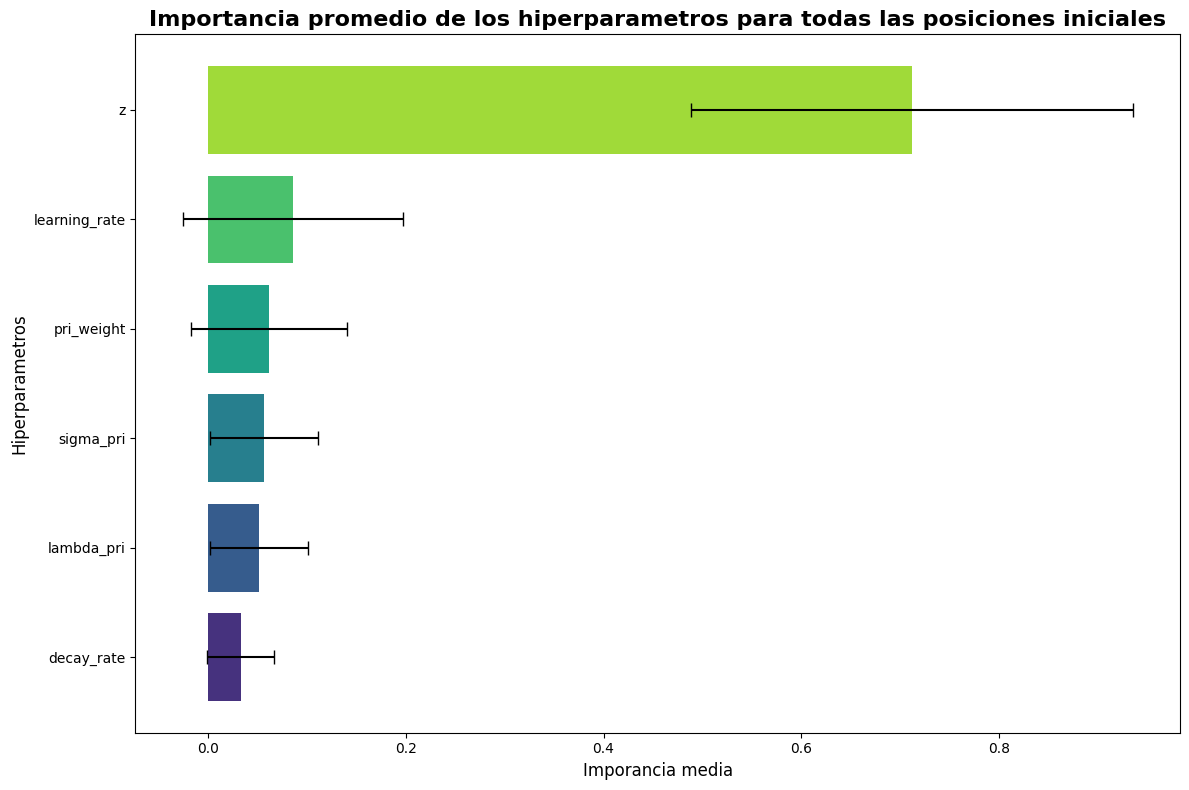


Best Hyperparameters Found:
  z: 6.413586134824273
  pri_weight: 1.0
  lambda_pri: 0.0
  sigma_pri: 27.516000747680664
  learning_rate: 0.26825984933403063
  decay_rate: 0.99


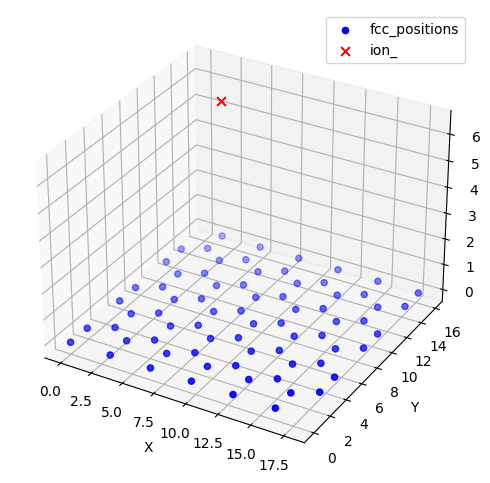

Epoch 1/300
Loss: -0.19561767578125 MeanGrad: [ 0.02233925 -0.49662805  0.07490897]
Epoch 2/300
Loss: -3.3962087631225586 MeanGrad: [ 0.04675601 -0.30423403  0.41275764]
Epoch 3/300
Loss: -6.6416015625 MeanGrad: [-0.18022242 -0.4642844   0.7453239 ]
Epoch 4/300
Loss: -3.952427864074707 MeanGrad: [-0.18297037 -0.7520495   0.57331896]
Epoch 5/300
Loss: -1.4459991455078125 MeanGrad: [ 0.06264664 -0.8793741   0.4708495 ]
| Loss: -1.4460 | LR: 0.2661
Epoch 6/300
Loss: -4.895159721374512 MeanGrad: [-0.21620116 -0.88503575  0.843169  ]
Epoch 7/300
Loss: -5.400943756103516 MeanGrad: [-0.21671137 -0.9123755   0.9953098 ]
Epoch 8/300
Loss: -5.967288017272949 MeanGrad: [-0.21150368 -0.93384707  1.1701756 ]
Epoch 9/300
Loss: -3.6431655883789062 MeanGrad: [ 0.09743828 -0.9769141   1.1863656 ]
Epoch 10/300
Loss: -7.275007247924805 MeanGrad: [-0.19101459 -1.0352955   1.6032798 ]
| Loss: -7.2750 | LR: 0.2635
Epoch 11/300
Loss: -8.053504943847656 MeanGrad: [-0.18280149 -1.0268074   1.8814151 ]
Epoch 12

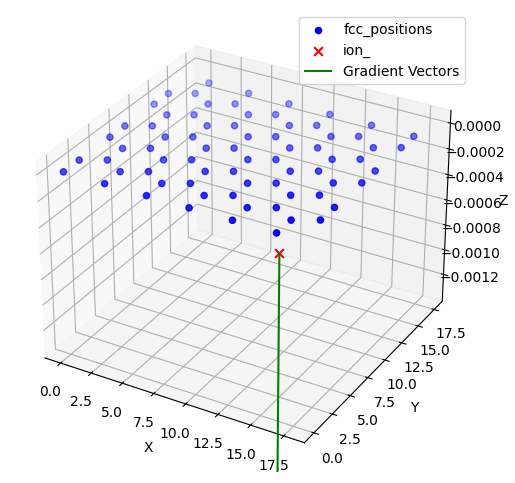

Epoch 152/300
Loss: -25.11414909362793 MeanGrad: [-0.00101285 -0.00322962 -0.00042225]
Epoch 153/300
Loss: -25.114151000976562 MeanGrad: [ 0.00319152 -0.00319624 -0.00031482]
Epoch 154/300
Loss: -25.11414909362793 MeanGrad: [ 0.00574213 -0.0012598  -0.00021589]
Epoch 155/300
Loss: -25.114147186279297 MeanGrad: [ 0.00578574  0.00123978 -0.00012433]
| Loss: -25.1141 | LR: 0.1968
Epoch 156/300
Loss: -25.114147186279297 MeanGrad: [ 3.5808682e-03  2.7422905e-03 -3.9898776e-05]
Epoch 157/300
Loss: -25.114147186279297 MeanGrad: [1.9455701e-04 2.4580956e-03 3.6846599e-05]
Epoch 158/300
Loss: -25.114151000976562 MeanGrad: [-0.00293768  0.00072193  0.00010533]
Epoch 159/300
Loss: -25.114147186279297 MeanGrad: [-0.00460565 -0.00129795  0.0001656 ]
Epoch 160/300
Loss: -25.11414909362793 MeanGrad: [-0.00431053 -0.00231171  0.00021835]
| Loss: -25.1141 | LR: 0.1949
Epoch 161/300
Loss: -25.11414909362793 MeanGrad: [-0.00233947 -0.00182152  0.00026441]
Epoch 162/300
Loss: -25.11414337158203 MeanGrad: 

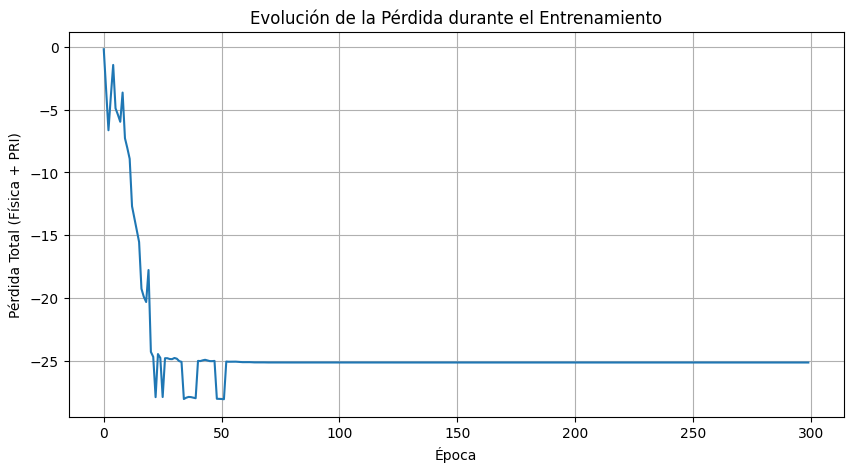

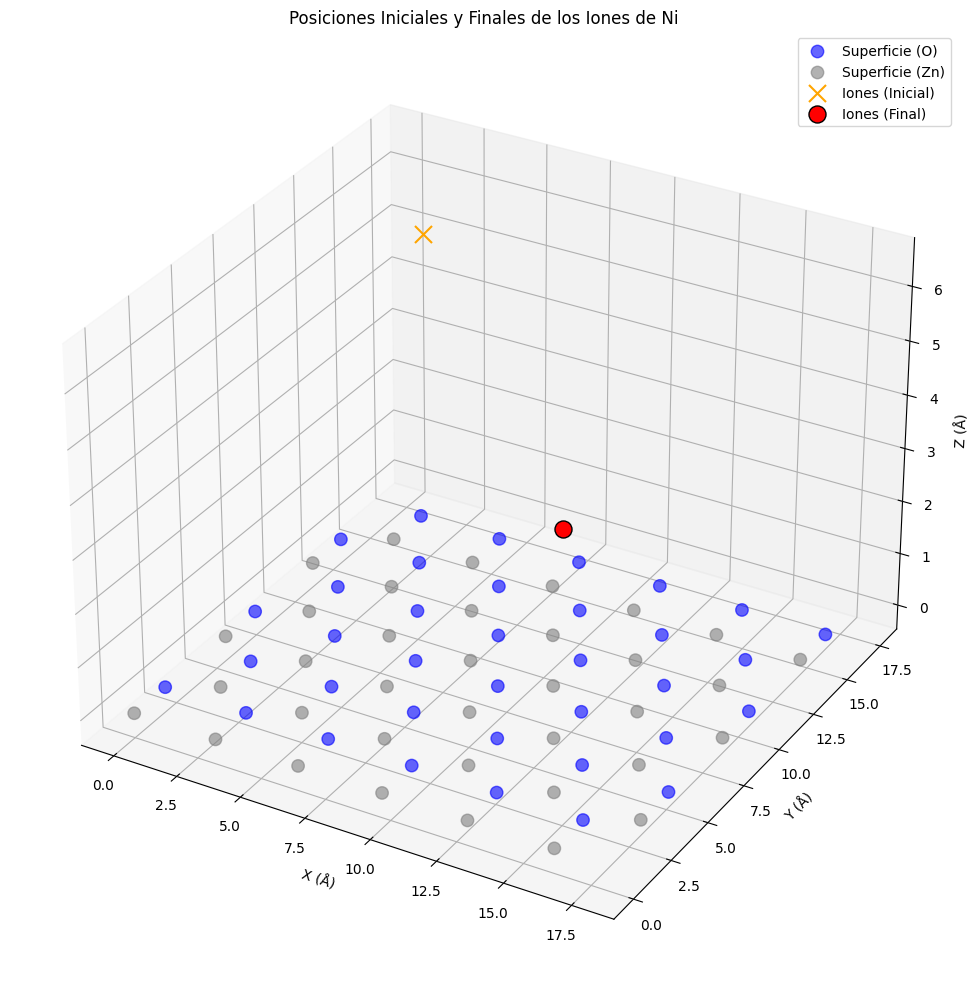

In [23]:
#ejecutamos todo para la muestra 1
puntos_por_eje = 50
k = 30
num_ni = 1
num_trials = 50
Studies,Trials = optimization(positions, puntos_por_eje, k, num_ni,num_trials,random_seed=42)
best_study = optimization_results(Studies, Trials)
epochs = 300
ion_final, ion_final_, starting_pos, loss_history, gradN_3D = training_loop(best_study, epochs,  positions, sample_atoms, sample_elements)
test_and_review(sample_atoms,sample_elements,ion_final,num_atoms, num_ni,starting_pos,loss_history,elements,positions,ion_final_,gradN_3D)